In [1]:
%matplotlib notebook

import json
import numpy as np
import numpy.random as npr
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
BURN_IN = 20

base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

In [3]:
with open('data.json', 'r') as f:
    raw_data = {literal_eval(k): v for k, v in json.load(f).items()}
    
for key in raw_data.keys():
    solver, params = key
    timeseries = raw_data[key][1]

    if solver == 'CBM':
        for species in ['P', 'RNA']:
            timeseries[species] = np.array(timeseries[species + 'nuc']) + np.array(timeseries[species + 'cyt'])
            del timeseries[species + 'nuc']
            del timeseries[species + 'cyt']

    del timeseries['Gf']
    del timeseries['Gb']

    for species in timeseries:
        timeseries[species] = np.array(timeseries[species])[:, BURN_IN:]
        
        

summary_statistics_raw = {
            'mean': lambda x: np.mean(x),
            'std': lambda x: np.std(x),
            'min': lambda x: np.min(x),
            'max': lambda x: np.max(x),
            }

stat_mean = {k + species: np.mean([s(v[1][species]) for v in raw_data.values()])
                for k, s in summary_statistics_raw.items()
                for species in ['P', 'RNA']}

stat_std = {k + species: np.std([s(v[1][species]) for v in raw_data.values()])
                for k, s in summary_statistics_raw.items()
                for species in ['P', 'RNA']}

In [4]:
# Pick 64 indices, do that K times (100?) start with K=10
K = 100
NTRAJ = 64

var_ss_dist = {solver:
           {k: [] for _, k in raw_data}
           for solver in ['CBM', 'WMM', 'smoldyn']
          }

var_ks_dist = {solver:
           {k: [] for _, k in raw_data}
           for solver in ['CBM', 'WMM', 'smoldyn']
          }

for k in range(K):
    subsample = npr.choice(list(range(NTRAJ)), NTRAJ)

    summary_statistics = {
                k + species: lambda x: (s(x[subsample,:]) - stat_mean[k + species])/stat_std[k + species]
                for k, s in summary_statistics_raw.items()
                for species in ['P', 'RNA']
            }

    lst_square = lambda x,y: (
            (np.array([summary_statistics[k + species](x[species])
                       for k in summary_statistics_raw.keys()
                       for species in ['P', 'RNA']])
            - (np.array([summary_statistics[k + species](y[species])
                       for k in summary_statistics_raw.keys()
                       for species in ['P', 'RNA']]))
        )**2).sum()**0.5
    
    

    # Refactor data
    data = {}
    for k, v in raw_data.items():
        solver, params = k
        data.setdefault(params, {})[solver] = v

    synthetic_data = [
        (0.8000000000000007, 0.8000000000000003, 0.0),
        (-0.7999999999999998, 0.8000000000000003, 0.0),
        (-4.8, 3.2, 0.0),
    ][0]

    ss_dist = {solver:
               {k:
                  lst_square(data[synthetic_data]['smoldyn'][1], v[solver][1])
                  for k, v in data.items()
                  if 'smoldyn' in v and solver in v
                  }
               for solver in ['CBM', 'WMM', 'smoldyn']
              }

    ks_dist = {solver:
               {k:
                sum([scs.ks_2samp(
                    data[synthetic_data]['smoldyn'][1][species][subsample,:].reshape(-1),
                    v[solver][1][species][subsample, :].reshape(-1))[0]
                  for species in ['P', 'RNA']])/2
                  for k, v in data.items()
                  if 'smoldyn' in v and solver in v
                  }
               for solver in ['CBM', 'WMM', 'smoldyn']
              }    
    
    for solver in ['CBM', 'WMM', 'smoldyn']:
        for k, v in data.items():
            var_ss_dist[solver][k].append(ss_dist[solver][k])
            var_ks_dist[solver][k].append(ks_dist[solver][k])
            
for solver in ['CBM', 'WMM', 'smoldyn']:
    for k, v in data.items():
        var_ss_dist[solver][k] = np.std(var_ss_dist[solver][k])
        var_ks_dist[solver][k] = np.std(var_ks_dist[solver][k])

<IPython.core.display.Javascript object>


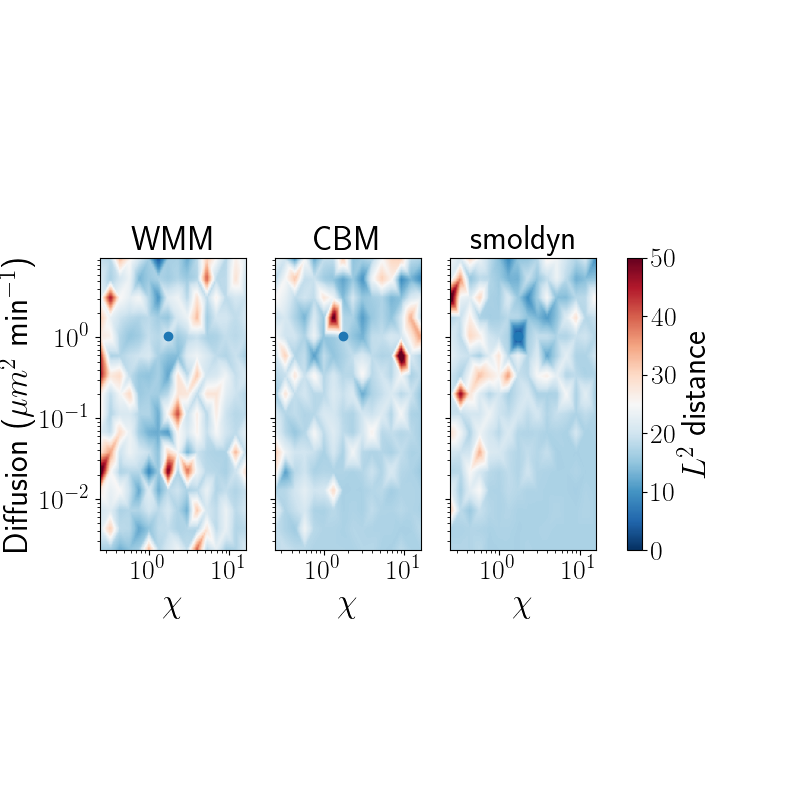

In [7]:
params = {'legend.fontsize': 20,
          #'figure.figsize': (6, 6),
         'figure.figsize': (8, 8),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'text.usetex':True,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

import scipy.interpolate as sci
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
#fig.tight_layout(w_pad=0)

dist = var_ss_dist

for i, solver in enumerate(['WMM', 'CBM', 'smoldyn']):
    dist_sol = dist[solver]

    min_x = log_value(min(dist_sol.keys(), key=lambda t: t[1])[1])
    max_x = log_value(max(dist_sol.keys(), key=lambda t: t[1])[1])
    min_D = log_value(min(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')
    max_D = log_value(max(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')

    raw_grid = np.array([[log_value(chi), log_value(D, 'diffusion'), z]
                         for ((D, chi, k_d), z) in dist_sol.items()
                        if k_d == 0])

    XY = raw_grid[:, :2]
    Z = raw_grid[:, 2]

    xi, yi = np.mgrid[min_x:max_x:100j, min_D:max_D:100j]
    grid_z2 = sci.griddata(XY, Z, (xi, yi) , method='linear')

    pcm = ax[i].imshow(grid_z2.T, extent=(min_x, max_x, min_D, max_D),
               #norm=colors.LogNorm(),
               vmin=0, vmax=50,
               origin='lower', cmap='RdBu_r')

    if not i:
        ax[i].set_ylabel('Diffusion ($\mu m^2$ min$^{-1}$)')

    ax[i].set_xlabel('$\chi$')
    
    ax[i].set_title(f"{solver}")

    xticks = list(range(int(np.ceil(min_x)), int(np.floor(max_x))+1))
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
    ax[i].xaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    yticks = list(range(int(np.ceil(min_D)), int(np.floor(max_D))+1))
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
    ax[i].yaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    ax[i].scatter(log_value(synthetic_data[1]), log_value(synthetic_data[0], 'diffusion'))
    
cb = fig.colorbar(pcm, ax=ax[:], location='right', shrink=0.475)
cb.set_label('$L^2$ distance')